In [1]:
import random
import threading
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from parameters import *
from utils import next_train, initialization, get_next_starting_Time, get_ActiveSchedule, get_df_ofPassengers, arrival_time

sa_neighbors=3
T=0  # 轻微跳跃
cooling_rate=0.95

In [2]:
df=pd.read_csv('../shenzhen_data/morning_longtime_100000(processed).csv')
df.drop_duplicates(inplace=True)
print(df.shape, df.columns)
df.sort_values(by=['time'], inplace=True)
df['time']=df['time']+2*int(stations_N*2*(skipped_saved+station_interval)) # 提前一定时间开始运营地铁，发出的第一台车跑完一圈就开始接待高峰期乘客
print(passenger_max)
df.head(2)

(10000, 7) Index(['start', 'end', 'time', 'id', 'forward', 'start_', 'end_'], dtype='object')
75


,start,end,time,id,forward,start_,end_
4936,23,13,270,94603,0,26,36
9127,2,17,270,13973,1,2,17


In [3]:
# initialization 后的StartTrain_time是上一台已经发车的列车的时间，故在while里面要新建
# df_schedule, StartTrain_time=initialization()

# while StartTrain_time<final_time:
#     StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule, StartTrain_time)) 
#     temp_schedule=next_train(stop_stations=list(np.ones(stations_N*2).astype(int)), StartTrain_time=StartTrain_time)
#     df_schedule=pd.concat([df_schedule, temp_schedule])
# df_schedule.reset_index(drop=True, inplace=True)
# df_schedule
df_schedule=pd.read_csv('../result/df_schedule_al1.csv')
print(df_schedule.shape, df_schedule.columns)
df_schedule.head(5)

(123, 101) Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '41_stop', '42_stop', '43_stop', '44_stop', '45_stop', '46_stop',
       '47_stop', '48_stop', '49_stop', 'restart_time'],
      dtype='object', length=101)


,0,1,2,3,4,5,6,7,8,9,...,41_stop,42_stop,43_stop,44_stop,45_stop,46_stop,47_stop,48_stop,49_stop,restart_time
0,0.0,2.7,5.4,8.1,10.8,13.5,16.2,18.9,21.6,24.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,135.0
1,5.0,7.7,10.4,13.1,15.8,18.5,21.2,23.9,26.6,29.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,140.0
2,10.0,12.7,15.4,18.1,20.8,23.5,26.2,28.9,31.6,34.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,145.0
3,15.0,17.7,20.4,23.1,25.8,28.5,31.2,33.9,36.6,39.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,150.0
4,20.0,22.7,25.4,28.1,30.8,33.5,36.2,38.9,41.6,44.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,155.0


In [4]:
def new_neighbor_schedule(df_schedule,sa_neighbors=sa_neighbors):
    random_indices = [(random.randint(train_N, len(df_schedule)-2), random.choice(column_names_with_stop)) for _ in range(sa_neighbors)] #数据去头去尾
    for index, col in random_indices:
        df_schedule.at[index, col] = random.choice([0, 1])
    df_schedule_temp, StartTrain_time=initialization()
    init_n=len(df_schedule_temp)
    assert train_N==init_n
    for i in range(train_N, len(df_schedule)):
        StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule_temp, StartTrain_time)) 
        temp_schedule=next_train(stop_stations=list(df_schedule[column_names_with_stop].iloc[i]), 
                                StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
    df_schedule_temp.reset_index(drop=True, inplace=True)
    df_schedule=df_schedule_temp.copy()

    return df_schedule

def heat_func(delta, T):
    if delta<=0:
        return 1
    else:
        return np.e**(-delta/T)        
    

In [5]:
###
print(new_neighbor_schedule(df_schedule.copy(),3).sum().sum())
df_schedule.sum().sum()


2288966.0999999964


2289079.6999999965

In [6]:
def calculating_waiting_time_for_SA(df_schedule, df,result_t=None, result_df=None):
    waiting_time=0
    waiting_time_list=[]
    station_interval_list=[]
    df_changing=df.copy()
    df_schedule_temp=pd.DataFrame()
    for i in range(df_schedule.shape[0]):
        temp_schedule=df_schedule.iloc[[i]]
        stop_stations=temp_schedule.T.reset_index()[stations_N*2:stations_N*4][i].values
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        # print("stop_stations:", stop_stations)

    #
    while df_changing.shape[0]>0:
        print('a new shcedule is generated')
        stop_stations=list(np.ones(stations_N*2).astype(int))
        StartTrain_time=df_schedule_temp['restart_time'].iloc[-train_N:].min()  # 已经在运行列车最早回来的值
        temp_schedule=next_train(stop_stations=stop_stations, StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_schedule_temp.reset_index(drop=True, inplace=True)
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
#         print("stop_stations:", stop_stations)
        
    df_schedule_temp.reset_index(drop=True, inplace=True)
    if result_t!=None:
        result_t.append(waiting_time)
        result_df.append(df_schedule)
    return waiting_time, df_schedule_temp

In [7]:
costTime_best, df_schedule=calculating_waiting_time_for_SA(df_schedule=df_schedule.copy(), df=df.copy())
df_schedule=df_schedule
ref_time=costTime_best
result=[]
for i in tqdm(range(3000)):
    df_schedule_temp=new_neighbor_schedule(df_schedule.copy())
    costTime_temp,df_schedule_temp = calculating_waiting_time_for_SA(df_schedule=df_schedule_temp.copy(), df=df.copy())
    delta=costTime_best-costTime_temp
    print(df_schedule.shape[0], df_schedule_temp.shape[0])
    if delta>0:
        costTime_best=costTime_temp
        df_schedule=df_schedule_temp.copy()
    else:
        pass
    result.append(costTime_temp)
    print('original_time:', ref_time, 'optimization_time:', costTime_temp)

  0%|          | 1/3000 [00:26<21:57:55, 26.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272890.8999999893


  0%|          | 2/3000 [00:52<21:43:29, 26.09s/it]

123 123
original_time: 272849.6999999893 optimization_time: 275674.49999998935


  0%|          | 3/3000 [01:17<21:16:12, 25.55s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273441.69999998936


  0%|          | 4/3000 [01:42<21:14:22, 25.52s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272798.8999999893


  0%|          | 5/3000 [02:08<21:14:21, 25.53s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273095.49999998946


  0%|          | 6/3000 [02:34<21:22:44, 25.71s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272798.8999999893


  0%|          | 7/3000 [02:59<21:15:42, 25.57s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272798.8999999893


  0%|          | 8/3000 [03:25<21:15:33, 25.58s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273228.69999998936


  0%|          | 9/3000 [03:50<21:07:09, 25.42s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272803.89999998943


  0%|          | 10/3000 [04:15<20:59:58, 25.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273194.8999999893


  0%|          | 11/3000 [04:40<21:01:58, 25.33s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272798.8999999893


  0%|          | 12/3000 [05:06<21:03:33, 25.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273989.8999999892


  0%|          | 13/3000 [05:31<21:08:53, 25.49s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272804.2999999894


  0%|          | 14/3000 [05:57<21:05:55, 25.44s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273323.69999998924


  0%|          | 15/3000 [06:22<21:09:03, 25.51s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272766.69999998936


  1%|          | 16/3000 [06:48<21:12:57, 25.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273126.4999999893


  1%|          | 17/3000 [07:14<21:09:56, 25.54s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272684.2999999892


  1%|          | 18/3000 [07:39<21:03:06, 25.41s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273648.0999999893


  1%|          | 19/3000 [08:04<21:00:38, 25.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272845.6999999892


  1%|          | 20/3000 [08:29<20:56:14, 25.29s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273131.2999999892


  1%|          | 21/3000 [08:55<20:59:35, 25.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273554.89999998925


  1%|          | 22/3000 [09:20<20:55:29, 25.30s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272684.2999999892


  1%|          | 23/3000 [09:46<21:04:31, 25.49s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272684.2999999892


  1%|          | 24/3000 [10:11<21:07:03, 25.55s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272653.4999999892


  1%|          | 25/3000 [10:37<21:07:54, 25.57s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272712.2999999893


  1%|          | 26/3000 [11:03<21:08:58, 25.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273245.29999998916


  1%|          | 27/3000 [11:28<20:59:16, 25.41s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272653.4999999892


  1%|          | 28/3000 [11:53<20:56:45, 25.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273803.09999998927


  1%|          | 29/3000 [12:19<21:01:11, 25.47s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273043.89999998925


  1%|          | 30/3000 [12:44<21:01:41, 25.49s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272653.4999999892


  1%|          | 31/3000 [13:10<21:01:12, 25.49s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273251.49999998923


  1%|          | 32/3000 [13:35<21:02:02, 25.51s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273032.89999998925


  1%|          | 33/3000 [14:01<21:09:55, 25.68s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273787.0999999892


  1%|          | 34/3000 [14:27<21:07:17, 25.64s/it]

123 123
original_time: 272849.6999999893 optimization_time: 275468.09999998915


  1%|          | 35/3000 [14:52<21:03:37, 25.57s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273800.09999998927


  1%|          | 36/3000 [15:18<20:59:12, 25.49s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272653.4999999892


  1%|          | 37/3000 [15:41<20:23:12, 24.77s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272653.4999999892


  1%|▏         | 38/3000 [16:05<20:15:49, 24.63s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273026.8999999892


  1%|▏         | 39/3000 [16:30<20:26:13, 24.85s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273066.0999999892


  1%|▏         | 40/3000 [16:56<20:44:12, 25.22s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272670.8999999892


  1%|▏         | 41/3000 [17:22<20:52:08, 25.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272602.8999999892


  1%|▏         | 42/3000 [17:48<20:54:24, 25.44s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272621.09999998903


  1%|▏         | 43/3000 [18:13<20:48:49, 25.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272613.6999999892


  1%|▏         | 44/3000 [18:38<20:46:57, 25.31s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272602.8999999892


  2%|▏         | 45/3000 [19:00<19:55:45, 24.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274760.09999998927


  2%|▏         | 46/3000 [19:24<19:48:34, 24.14s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273182.2999999892


  2%|▏         | 47/3000 [19:47<19:34:59, 23.87s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272602.0999999892


  2%|▏         | 48/3000 [20:10<19:28:12, 23.74s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273856.6999999891


  2%|▏         | 49/3000 [20:33<19:16:11, 23.51s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274415.6999999892


  2%|▏         | 50/3000 [20:56<19:07:19, 23.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272602.0999999892


  2%|▏         | 51/3000 [21:19<19:03:55, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273022.49999998923


  2%|▏         | 52/3000 [21:42<19:00:01, 23.20s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273308.49999998923


  2%|▏         | 53/3000 [22:05<18:55:02, 23.11s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273708.4999999891


  2%|▏         | 54/3000 [22:28<18:48:41, 22.99s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272943.8999999892


  2%|▏         | 55/3000 [22:51<18:44:23, 22.91s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272625.89999998925


  2%|▏         | 56/3000 [23:13<18:40:11, 22.83s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272602.0999999892


  2%|▏         | 57/3000 [23:36<18:38:57, 22.81s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273544.0999999893


  2%|▏         | 58/3000 [23:58<18:20:37, 22.45s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272343.6999999892


  2%|▏         | 59/3000 [24:21<18:29:54, 22.64s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272684.2999999892


  2%|▏         | 60/3000 [24:44<18:39:26, 22.85s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272491.29999998934


  2%|▏         | 61/3000 [25:08<18:45:23, 22.97s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272357.09999998915


  2%|▏         | 62/3000 [25:31<18:56:44, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272380.4999999892


  2%|▏         | 63/3000 [25:55<19:01:25, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272598.0999999893


  2%|▏         | 64/3000 [26:18<19:05:11, 23.40s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272327.0999999892


  2%|▏         | 65/3000 [26:42<19:10:33, 23.52s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272959.09999998927


  2%|▏         | 66/3000 [27:06<19:15:07, 23.62s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273774.8999999892


  2%|▏         | 67/3000 [27:30<19:13:40, 23.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272327.0999999892


  2%|▏         | 68/3000 [27:53<19:12:27, 23.58s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273469.89999998925


  2%|▏         | 69/3000 [28:17<19:13:03, 23.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272418.6999999893


  2%|▏         | 70/3000 [28:41<19:17:36, 23.71s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272327.0999999892


  2%|▏         | 71/3000 [29:04<19:16:34, 23.69s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272986.29999998916


  2%|▏         | 72/3000 [29:28<19:14:39, 23.66s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272528.29999998916


  2%|▏         | 73/3000 [29:51<19:11:13, 23.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272748.6999999892


  2%|▏         | 74/3000 [30:15<19:09:05, 23.56s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272342.29999998905


  2%|▎         | 75/3000 [30:39<19:08:27, 23.56s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272343.49999998923


  3%|▎         | 76/3000 [31:02<19:09:50, 23.59s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272337.69999998924


  3%|▎         | 77/3000 [31:25<19:04:53, 23.50s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272909.89999998925


  3%|▎         | 78/3000 [31:49<18:58:55, 23.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272377.0999999893


  3%|▎         | 79/3000 [32:12<19:00:07, 23.42s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272324.6999999893


  3%|▎         | 80/3000 [32:35<18:58:28, 23.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273436.49999998923


  3%|▎         | 81/3000 [32:59<18:57:31, 23.38s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274244.49999998923


  3%|▎         | 82/3000 [33:22<18:57:33, 23.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272829.49999998923


  3%|▎         | 83/3000 [33:46<18:57:22, 23.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272324.89999998925


  3%|▎         | 84/3000 [34:09<18:57:40, 23.41s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272324.6999999893


  3%|▎         | 85/3000 [34:33<18:58:09, 23.43s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273439.29999998916


  3%|▎         | 86/3000 [34:56<18:56:54, 23.41s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272277.89999998943


  3%|▎         | 87/3000 [35:20<19:01:12, 23.51s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272535.89999998943


  3%|▎         | 88/3000 [35:43<18:59:30, 23.48s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272277.89999998943


  3%|▎         | 89/3000 [36:06<18:54:11, 23.38s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274174.49999998923


  3%|▎         | 98/3000 [39:37<18:53:23, 23.43s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272755.89999998925


  3%|▎         | 99/3000 [40:00<18:50:52, 23.39s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274236.49999998946


  3%|▎         | 100/3000 [40:24<18:52:49, 23.44s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272873.29999998945


  3%|▎         | 101/3000 [40:47<18:51:26, 23.42s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272272.09999998944


  3%|▎         | 102/3000 [41:10<18:50:04, 23.40s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272413.89999998943


  3%|▎         | 103/3000 [41:34<18:51:19, 23.43s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272272.09999998944


  3%|▎         | 104/3000 [41:57<18:47:47, 23.37s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272272.09999998944


  4%|▎         | 105/3000 [42:20<18:46:01, 23.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273990.49999998935


  4%|▎         | 106/3000 [42:44<18:46:19, 23.35s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272313.2999999894


  4%|▎         | 107/3000 [43:07<18:45:23, 23.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272744.2999999894


  4%|▎         | 108/3000 [43:30<18:43:55, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273137.2999999893


  4%|▎         | 109/3000 [43:54<18:43:17, 23.31s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273200.2999999894


  4%|▎         | 110/3000 [44:17<18:43:06, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273919.4999999894


  4%|▎         | 111/3000 [44:40<18:42:18, 23.31s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272324.09999998944


  4%|▎         | 112/3000 [45:04<18:42:52, 23.33s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272609.0999999894


  4%|▍         | 113/3000 [45:27<18:41:55, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272272.09999998944


  4%|▍         | 114/3000 [45:50<18:36:38, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273759.0999999893


  4%|▍         | 115/3000 [46:13<18:34:41, 23.18s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272338.8999999894


  4%|▍         | 116/3000 [46:36<18:35:14, 23.20s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272272.09999998944


  4%|▍         | 117/3000 [47:00<18:39:02, 23.29s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272926.8999999894


  4%|▍         | 118/3000 [47:23<18:40:03, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272276.8999999895


  4%|▍         | 119/3000 [47:47<18:41:25, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272109.6999999894


  4%|▍         | 120/3000 [48:10<18:42:26, 23.38s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273309.29999998934


  4%|▍         | 121/3000 [48:33<18:40:42, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272109.6999999894


  4%|▍         | 122/3000 [48:57<18:39:49, 23.35s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274858.4999999894


  4%|▍         | 123/3000 [49:20<18:37:59, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273593.09999998944


  4%|▍         | 124/3000 [49:43<18:39:35, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272096.8999999894


  4%|▍         | 125/3000 [50:07<18:40:09, 23.38s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273061.49999998935


  4%|▍         | 126/3000 [50:30<18:39:02, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272107.0999999894


  4%|▍         | 127/3000 [50:53<18:37:27, 23.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272641.0999999894


  4%|▍         | 128/3000 [51:17<18:33:50, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274032.09999998927


  4%|▍         | 129/3000 [51:40<18:31:01, 23.22s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272096.8999999894


  4%|▍         | 130/3000 [52:03<18:30:09, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274577.89999998925


  4%|▍         | 131/3000 [52:26<18:32:54, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 276349.2999999893


  4%|▍         | 132/3000 [52:49<18:30:47, 23.24s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272096.8999999894


  4%|▍         | 133/3000 [53:13<18:28:43, 23.20s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272281.2999999894


  4%|▍         | 134/3000 [53:36<18:29:09, 23.22s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272096.8999999894


  4%|▍         | 135/3000 [53:59<18:27:11, 23.19s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273325.2999999893


  5%|▍         | 136/3000 [54:22<18:28:07, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272485.89999998943


  5%|▍         | 137/3000 [54:46<18:28:54, 23.24s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272106.0999999894


  5%|▍         | 138/3000 [55:09<18:27:45, 23.22s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272667.8999999894


  5%|▍         | 139/3000 [55:32<18:29:15, 23.26s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272096.8999999894


  5%|▍         | 140/3000 [55:55<18:29:40, 23.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274670.89999998925


  5%|▍         | 141/3000 [56:19<18:33:20, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272524.4999999893


  5%|▍         | 142/3000 [56:42<18:34:35, 23.40s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272408.6999999894


  5%|▍         | 143/3000 [57:06<18:31:19, 23.34s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272706.2999999893


  5%|▍         | 144/3000 [57:29<18:31:25, 23.35s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272006.89999998925


  5%|▍         | 145/3000 [57:52<18:29:42, 23.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272185.6999999893


  5%|▍         | 146/3000 [58:15<18:27:03, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272006.89999998925


  5%|▍         | 147/3000 [58:38<18:23:27, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272167.2999999893


  5%|▍         | 148/3000 [59:02<18:25:03, 23.25s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272006.89999998925


  5%|▍         | 149/3000 [59:25<18:26:23, 23.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  5%|▌         | 150/3000 [59:49<18:31:18, 23.40s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272890.6999999893


  5%|▌         | 151/3000 [1:00:12<18:29:16, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272207.8999999894


  5%|▌         | 152/3000 [1:00:35<18:25:01, 23.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271792.0999999893


  5%|▌         | 153/3000 [1:00:58<18:24:00, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271801.8999999894


  5%|▌         | 154/3000 [1:01:22<18:27:55, 23.36s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272180.8999999893


  5%|▌         | 155/3000 [1:01:45<18:27:01, 23.35s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  5%|▌         | 156/3000 [1:02:08<18:24:07, 23.29s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272871.0999999893


  5%|▌         | 157/3000 [1:02:32<18:23:10, 23.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273655.49999998935


  5%|▌         | 158/3000 [1:02:55<18:22:23, 23.27s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272350.2999999893


  5%|▌         | 159/3000 [1:03:18<18:18:01, 23.19s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272831.0999999893


  5%|▌         | 160/3000 [1:03:41<18:14:54, 23.13s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272365.69999998936


  5%|▌         | 161/3000 [1:04:04<18:17:52, 23.20s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272556.49999998935


  5%|▌         | 162/3000 [1:04:28<18:16:40, 23.19s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273515.69999998936


  5%|▌         | 163/3000 [1:04:51<18:17:16, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  5%|▌         | 164/3000 [1:05:14<18:17:02, 23.21s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272154.4999999894


  6%|▌         | 165/3000 [1:05:37<18:13:22, 23.14s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271829.8999999893


  6%|▌         | 166/3000 [1:06:00<18:12:50, 23.14s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272011.09999998927


  6%|▌         | 167/3000 [1:06:23<18:07:31, 23.03s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  6%|▌         | 168/3000 [1:06:46<18:07:06, 23.03s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271796.8999999894


  6%|▌         | 169/3000 [1:07:09<18:07:50, 23.06s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272147.8999999894


  6%|▌         | 170/3000 [1:07:32<18:07:12, 23.05s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271827.0999999893


  6%|▌         | 171/3000 [1:07:55<18:05:46, 23.03s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272489.2999999894


  6%|▌         | 172/3000 [1:08:18<18:04:24, 23.01s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272386.29999998945


  6%|▌         | 173/3000 [1:08:40<17:46:30, 22.64s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  6%|▌         | 174/3000 [1:09:00<17:18:53, 22.06s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272160.69999998924


  6%|▌         | 175/3000 [1:09:21<16:57:01, 21.60s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271795.2999999893


  6%|▌         | 176/3000 [1:09:42<16:42:11, 21.29s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  6%|▌         | 177/3000 [1:10:02<16:34:24, 21.14s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  6%|▌         | 178/3000 [1:10:24<16:40:45, 21.28s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271794.49999998935


  6%|▌         | 179/3000 [1:10:45<16:42:10, 21.32s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272006.2999999894


  6%|▌         | 180/3000 [1:11:06<16:34:03, 21.15s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272930.29999998934


  6%|▌         | 181/3000 [1:11:27<16:26:35, 21.00s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272884.6999999895


  6%|▌         | 182/3000 [1:11:48<16:29:34, 21.07s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273025.49999998935


  6%|▌         | 183/3000 [1:12:09<16:25:31, 20.99s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272831.0999999893


  6%|▌         | 184/3000 [1:12:30<16:25:42, 21.00s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271780.2999999893


  6%|▌         | 185/3000 [1:12:51<16:22:24, 20.94s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271792.69999998936


  6%|▌         | 186/3000 [1:13:11<16:17:50, 20.85s/it]

123 123
original_time: 272849.6999999893 optimization_time: 273723.49999998935


  6%|▌         | 187/3000 [1:13:32<16:16:03, 20.82s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271777.0999999893


  6%|▋         | 188/3000 [1:13:53<16:18:19, 20.87s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272149.8999999894


  6%|▋         | 189/3000 [1:14:14<16:15:21, 20.82s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271723.69999998936


  6%|▋         | 190/3000 [1:14:34<16:13:02, 20.78s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271988.4999999894


  6%|▋         | 191/3000 [1:14:55<16:11:18, 20.75s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272283.8999999894


  6%|▋         | 192/3000 [1:15:16<16:18:32, 20.91s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271744.6999999893


  6%|▋         | 193/3000 [1:15:38<16:25:32, 21.07s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272963.69999998936


  6%|▋         | 194/3000 [1:15:59<16:28:50, 21.14s/it]

123 123
original_time: 272849.6999999893 optimization_time: 274081.49999998923


  6%|▋         | 195/3000 [1:16:20<16:27:48, 21.13s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271947.09999998927


  7%|▋         | 196/3000 [1:16:42<16:31:28, 21.22s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272855.6999999893


  7%|▋         | 197/3000 [1:17:03<16:35:11, 21.30s/it]

123 123
original_time: 272849.6999999893 optimization_time: 271723.69999998936


  7%|▋         | 198/3000 [1:17:25<16:39:50, 21.41s/it]

123 123
original_time: 272849.6999999893 optimization_time: 272016.49999998935


 21%|██        | 637/3000 [3:53:36<14:07:17, 21.51s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266981.0999999894


 21%|██▏       | 638/3000 [3:53:57<14:10:04, 21.59s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267768.2999999894


 21%|██▏       | 639/3000 [3:54:19<14:10:35, 21.62s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266493.49999998935


 21%|██▏       | 640/3000 [3:54:41<14:09:39, 21.60s/it]

124 124
original_time: 272849.6999999893 optimization_time: 268154.09999998944


 21%|██▏       | 641/3000 [3:55:02<14:08:49, 21.59s/it]

124 124
original_time: 272849.6999999893 optimization_time: 268176.29999998945


 21%|██▏       | 642/3000 [3:55:23<14:05:14, 21.51s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266735.6999999894


 21%|██▏       | 643/3000 [3:55:45<14:03:56, 21.48s/it]

124 124
original_time: 272849.6999999893 optimization_time: 268050.8999999893


 21%|██▏       | 644/3000 [3:56:06<14:00:52, 21.41s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266493.49999998935


 22%|██▏       | 645/3000 [3:56:28<14:02:37, 21.47s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266493.49999998935


 22%|██▏       | 646/3000 [3:56:49<14:05:40, 21.56s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266501.4999999894


 22%|██▏       | 647/3000 [3:57:11<14:04:20, 21.53s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267016.8999999894


 22%|██▏       | 648/3000 [3:57:32<14:03:01, 21.51s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267154.69999998936


 22%|██▏       | 649/3000 [3:57:54<14:03:54, 21.54s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267658.69999998936


 22%|██▏       | 650/3000 [3:58:16<14:11:59, 21.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267102.8999999893


 22%|██▏       | 651/3000 [3:58:40<14:29:18, 22.20s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266546.69999998936


 22%|██▏       | 652/3000 [3:59:03<14:43:15, 22.57s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266513.29999998934


 22%|██▏       | 653/3000 [3:59:26<14:49:49, 22.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266463.0999999893


 22%|██▏       | 654/3000 [3:59:49<14:54:11, 22.87s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266892.0999999893


 22%|██▏       | 655/3000 [4:00:12<14:51:18, 22.81s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266886.69999998936


 22%|██▏       | 656/3000 [4:00:35<14:48:43, 22.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267478.8999999893


 22%|██▏       | 657/3000 [4:00:58<14:57:38, 22.99s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266443.49999998935


 22%|██▏       | 658/3000 [4:01:22<15:06:02, 23.21s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266523.0999999893


 22%|██▏       | 659/3000 [4:01:45<15:08:41, 23.29s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267185.4999999894


 22%|██▏       | 660/3000 [4:02:09<15:07:50, 23.28s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266244.0999999893


 22%|██▏       | 661/3000 [4:02:32<15:08:38, 23.31s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267341.2999999894


 22%|██▏       | 662/3000 [4:02:55<15:04:52, 23.22s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 22%|██▏       | 663/3000 [4:03:18<15:00:41, 23.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267896.4999999894


 22%|██▏       | 664/3000 [4:03:41<15:00:19, 23.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 22%|██▏       | 665/3000 [4:04:04<14:59:01, 23.10s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266241.8999999894


 22%|██▏       | 666/3000 [4:04:28<15:03:01, 23.21s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266916.2999999893


 22%|██▏       | 667/3000 [4:04:51<15:05:56, 23.30s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267969.89999998943


 22%|██▏       | 668/3000 [4:05:14<15:02:25, 23.22s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266561.0999999894


 22%|██▏       | 669/3000 [4:05:37<15:02:19, 23.23s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266318.0999999894


 22%|██▏       | 670/3000 [4:06:01<15:04:56, 23.30s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266253.6999999894


 22%|██▏       | 671/3000 [4:06:25<15:12:24, 23.51s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 22%|██▏       | 672/3000 [4:06:49<15:17:44, 23.65s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 22%|██▏       | 673/3000 [4:07:13<15:18:47, 23.69s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267103.6999999894


 22%|██▏       | 674/3000 [4:07:36<15:21:33, 23.77s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 22%|██▎       | 675/3000 [4:08:00<15:16:03, 23.64s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266307.0999999894


 23%|██▎       | 676/3000 [4:08:23<15:14:22, 23.61s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266822.2999999894


 23%|██▎       | 677/3000 [4:08:47<15:19:23, 23.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266275.6999999894


 23%|██▎       | 678/3000 [4:09:12<15:25:41, 23.92s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266239.49999998935


 23%|██▎       | 679/3000 [4:09:36<15:28:29, 24.00s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266433.49999998935


 23%|██▎       | 680/3000 [4:10:00<15:23:43, 23.89s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266168.09999998944


 23%|██▎       | 681/3000 [4:10:22<15:06:34, 23.46s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265968.09999998944


 23%|██▎       | 682/3000 [4:10:43<14:42:46, 22.85s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266495.4999999895


 23%|██▎       | 683/3000 [4:11:05<14:22:30, 22.34s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266085.8999999894


 23%|██▎       | 684/3000 [4:11:26<14:10:28, 22.03s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265980.49999998946


 23%|██▎       | 685/3000 [4:11:47<13:57:43, 21.71s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265968.09999998944


 23%|██▎       | 686/3000 [4:12:08<13:52:50, 21.59s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265968.09999998944


 23%|██▎       | 687/3000 [4:12:30<13:52:15, 21.59s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266075.89999998943


 23%|██▎       | 688/3000 [4:12:51<13:51:11, 21.57s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265976.29999998945


 23%|██▎       | 689/3000 [4:13:12<13:46:14, 21.45s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266975.09999998944


 23%|██▎       | 690/3000 [4:13:34<13:43:37, 21.39s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266001.29999998945


 23%|██▎       | 691/3000 [4:13:55<13:43:25, 21.40s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265947.4999999895


 23%|██▎       | 692/3000 [4:14:16<13:39:01, 21.29s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266861.69999998953


 23%|██▎       | 693/3000 [4:14:37<13:32:46, 21.14s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265943.4999999895


 23%|██▎       | 694/3000 [4:14:58<13:31:45, 21.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265906.89999998955


 23%|██▎       | 695/3000 [4:15:20<13:36:34, 21.26s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265903.29999998957


 23%|██▎       | 696/3000 [4:15:41<13:40:07, 21.36s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265909.4999999895


 23%|██▎       | 697/3000 [4:16:02<13:31:26, 21.14s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266038.89999998966


 23%|██▎       | 698/3000 [4:16:23<13:31:29, 21.15s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265903.29999998957


 23%|██▎       | 699/3000 [4:16:44<13:24:48, 20.99s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266299.69999998953


 23%|██▎       | 700/3000 [4:17:04<13:21:22, 20.91s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266639.49999998964


 23%|██▎       | 701/3000 [4:17:26<13:26:47, 21.06s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265827.89999998955


 23%|██▎       | 702/3000 [4:17:47<13:27:11, 21.08s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265827.89999998955


 23%|██▎       | 703/3000 [4:18:08<13:30:16, 21.17s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266524.0999999895


 23%|██▎       | 704/3000 [4:18:30<13:33:53, 21.27s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265777.89999998955


 24%|██▎       | 705/3000 [4:18:51<13:37:28, 21.37s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266939.29999998957


 24%|██▎       | 706/3000 [4:19:12<13:34:16, 21.30s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265777.89999998955


 24%|██▎       | 707/3000 [4:19:34<13:31:25, 21.23s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265715.09999998944


 24%|██▎       | 708/3000 [4:19:55<13:31:57, 21.26s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266110.09999998956


 24%|██▎       | 709/3000 [4:20:16<13:32:04, 21.27s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265715.09999998944


 24%|██▎       | 710/3000 [4:20:37<13:29:39, 21.21s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265407.4999999896


 24%|██▎       | 711/3000 [4:20:59<13:31:53, 21.28s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265525.09999998956


 24%|██▎       | 712/3000 [4:21:20<13:34:20, 21.36s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265386.69999998953


 24%|██▍       | 713/3000 [4:21:42<13:34:52, 21.38s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265314.09999998956


 24%|██▍       | 714/3000 [4:22:04<13:47:03, 21.71s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265797.09999998956


 24%|██▍       | 715/3000 [4:22:26<13:46:59, 21.72s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265322.0999999895


 24%|██▍       | 716/3000 [4:22:47<13:45:02, 21.67s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265385.69999998953


 24%|██▍       | 717/3000 [4:23:10<13:49:29, 21.80s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265316.6999999896


 24%|██▍       | 718/3000 [4:23:31<13:43:49, 21.66s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265424.09999998944


 24%|██▍       | 719/3000 [4:23:52<13:37:16, 21.50s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265855.49999998964


 24%|██▍       | 720/3000 [4:24:14<13:44:52, 21.71s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265590.69999998953


 24%|██▍       | 721/3000 [4:24:37<13:57:08, 22.04s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265819.89999998955


 24%|██▍       | 722/3000 [4:25:00<14:07:27, 22.32s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265314.09999998956


 24%|██▍       | 723/3000 [4:25:23<14:13:21, 22.49s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265862.89999998943


 24%|██▍       | 724/3000 [4:25:46<14:18:03, 22.62s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265314.09999998956


 24%|██▍       | 725/3000 [4:26:09<14:22:35, 22.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265109.69999998953


 24%|██▍       | 726/3000 [4:26:32<14:22:00, 22.74s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265262.69999998953


 24%|██▍       | 727/3000 [4:26:53<14:10:03, 22.44s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265585.4999999894


 24%|██▍       | 728/3000 [4:27:16<14:13:15, 22.53s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265105.29999998957


 24%|██▍       | 729/3000 [4:27:39<14:14:28, 22.58s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265888.29999998957


 24%|██▍       | 730/3000 [4:28:01<14:13:07, 22.55s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265105.29999998957


 24%|██▍       | 731/3000 [4:28:24<14:12:14, 22.54s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265368.89999998955


 24%|██▍       | 732/3000 [4:28:47<14:18:14, 22.70s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266472.6999999896


 24%|██▍       | 733/3000 [4:29:10<14:26:52, 22.94s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265105.29999998957


 24%|██▍       | 734/3000 [4:29:34<14:30:38, 23.05s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265105.29999998957


 24%|██▍       | 735/3000 [4:29:57<14:33:16, 23.13s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265121.29999998957


 25%|██▍       | 736/3000 [4:30:20<14:34:04, 23.16s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265103.2999999896


 25%|██▍       | 737/3000 [4:30:43<14:34:43, 23.19s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265114.49999998964


 25%|██▍       | 738/3000 [4:31:07<14:34:11, 23.19s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265223.89999998955


 25%|██▍       | 739/3000 [4:31:30<14:34:05, 23.20s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265358.8999999896


 25%|██▍       | 740/3000 [4:31:52<14:17:08, 22.76s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265194.29999998957


 25%|██▍       | 741/3000 [4:32:15<14:20:14, 22.85s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266820.2999999896


 25%|██▍       | 742/3000 [4:32:37<14:18:09, 22.80s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265103.2999999896


 25%|██▍       | 743/3000 [4:33:00<14:18:23, 22.82s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264777.49999998964


 25%|██▍       | 744/3000 [4:33:23<14:18:01, 22.82s/it]

124 124
original_time: 272849.6999999893 optimization_time: 267107.09999998956


 25%|██▍       | 745/3000 [4:33:46<14:16:29, 22.79s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265760.6999999894


 25%|██▍       | 746/3000 [4:34:08<14:14:05, 22.74s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265031.4999999896


 25%|██▍       | 747/3000 [4:34:31<14:16:25, 22.81s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264777.49999998964


 25%|██▍       | 748/3000 [4:34:55<14:23:03, 22.99s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265950.09999998956


 25%|██▍       | 749/3000 [4:35:18<14:23:32, 23.02s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264777.49999998964


 25%|██▌       | 750/3000 [4:35:41<14:27:10, 23.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266925.89999998955


 25%|██▌       | 751/3000 [4:36:05<14:29:24, 23.19s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266647.8999999896


 25%|██▌       | 752/3000 [4:36:28<14:26:46, 23.13s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265147.69999998953


 25%|██▌       | 753/3000 [4:36:50<14:23:34, 23.06s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265270.0999999896


 25%|██▌       | 754/3000 [4:37:13<14:18:48, 22.94s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264949.49999998964


 25%|██▌       | 755/3000 [4:37:36<14:23:24, 23.08s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264991.4999999896


 25%|██▌       | 756/3000 [4:37:59<14:21:50, 23.04s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265083.4999999896


 25%|██▌       | 757/3000 [4:38:23<14:23:35, 23.10s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264754.69999998953


 25%|██▌       | 758/3000 [4:38:46<14:22:48, 23.09s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264779.4999999896


 25%|██▌       | 759/3000 [4:39:09<14:20:14, 23.03s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264572.49999998964


 25%|██▌       | 760/3000 [4:39:32<14:19:56, 23.03s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264683.4999999896


 25%|██▌       | 761/3000 [4:39:55<14:23:55, 23.15s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264572.49999998964


 25%|██▌       | 762/3000 [4:40:18<14:22:44, 23.13s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265330.8999999896


 25%|██▌       | 763/3000 [4:40:41<14:21:48, 23.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264583.0999999896


 25%|██▌       | 764/3000 [4:41:04<14:22:03, 23.13s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264716.89999998955


 26%|██▌       | 765/3000 [4:41:28<14:25:26, 23.23s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264576.8999999896


 26%|██▌       | 766/3000 [4:41:51<14:22:26, 23.16s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264959.0999999896


 26%|██▌       | 767/3000 [4:42:14<14:22:07, 23.17s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264585.4999999896


 26%|██▌       | 768/3000 [4:42:37<14:19:08, 23.10s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264475.09999998956


 26%|██▌       | 769/3000 [4:43:00<14:20:50, 23.15s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264570.29999998957


 26%|██▌       | 770/3000 [4:43:23<14:15:27, 23.02s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266180.29999998957


 26%|██▌       | 771/3000 [4:43:46<14:20:07, 23.15s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264419.89999998955


 26%|██▌       | 772/3000 [4:44:09<14:15:42, 23.04s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264532.0999999895


 26%|██▌       | 773/3000 [4:44:31<14:03:28, 22.72s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264500.29999998945


 26%|██▌       | 774/3000 [4:44:53<13:50:13, 22.38s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264635.8999999895


 26%|██▌       | 775/3000 [4:45:14<13:36:22, 22.01s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264419.89999998955


 26%|██▌       | 776/3000 [4:45:36<13:36:44, 22.03s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264395.2999999895


 26%|██▌       | 777/3000 [4:45:59<13:45:11, 22.27s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264395.2999999895


 26%|██▌       | 778/3000 [4:46:22<13:58:38, 22.65s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264340.69999998953


 26%|██▌       | 779/3000 [4:46:45<14:03:32, 22.79s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264431.09999998956


 26%|██▌       | 780/3000 [4:47:09<14:06:26, 22.88s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264320.8999999895


 26%|██▌       | 781/3000 [4:47:31<14:06:31, 22.89s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264428.6999999895


 26%|██▌       | 782/3000 [4:47:54<14:06:10, 22.89s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264320.8999999895


 26%|██▌       | 783/3000 [4:48:17<14:07:49, 22.95s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264652.29999998945


 26%|██▌       | 784/3000 [4:48:40<14:07:57, 22.96s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264308.2999999895


 26%|██▌       | 785/3000 [4:49:03<14:07:52, 22.97s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264270.89999998955


 26%|██▌       | 786/3000 [4:49:27<14:09:40, 23.03s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264268.4999999896


 26%|██▌       | 787/3000 [4:49:50<14:09:52, 23.04s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264241.8999999896


 26%|██▋       | 788/3000 [4:50:13<14:09:36, 23.05s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264241.8999999896


 26%|██▋       | 789/3000 [4:50:36<14:07:51, 23.01s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264206.29999998957


 26%|██▋       | 790/3000 [4:50:58<14:04:20, 22.92s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264200.0999999895


 26%|██▋       | 791/3000 [4:51:22<14:07:19, 23.01s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264797.8999999895


 26%|██▋       | 792/3000 [4:51:45<14:10:43, 23.12s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264494.0999999896


 26%|██▋       | 793/3000 [4:52:08<14:10:57, 23.13s/it]

124 124
original_time: 272849.6999999893 optimization_time: 266700.4999999895


 26%|██▋       | 794/3000 [4:52:31<14:05:10, 22.99s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264162.89999998955


 26%|██▋       | 795/3000 [4:52:54<14:05:23, 23.00s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265060.8999999896


 27%|██▋       | 796/3000 [4:53:17<14:07:00, 23.06s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264446.29999998957


 27%|██▋       | 797/3000 [4:53:40<14:06:26, 23.05s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263939.2999999895


 27%|██▋       | 798/3000 [4:54:03<14:03:13, 22.98s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263808.4999999894


 27%|██▋       | 799/3000 [4:54:25<13:50:44, 22.65s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265919.29999998945


 27%|██▋       | 800/3000 [4:54:46<13:38:36, 22.33s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264349.2999999895


 27%|██▋       | 801/3000 [4:55:07<13:22:46, 21.90s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263836.0999999894


 27%|██▋       | 802/3000 [4:55:29<13:21:31, 21.88s/it]

124 124
original_time: 272849.6999999893 optimization_time: 265102.6999999895


 27%|██▋       | 803/3000 [4:55:52<13:33:27, 22.22s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263808.4999999894


 27%|██▋       | 804/3000 [4:56:15<13:39:38, 22.39s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263616.4999999895


 27%|██▋       | 805/3000 [4:56:38<13:45:41, 22.57s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263617.89999998955


 27%|██▋       | 806/3000 [4:57:01<13:49:54, 22.70s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263631.6999999895


 27%|██▋       | 807/3000 [4:57:24<13:50:44, 22.73s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264064.29999998957


 27%|██▋       | 808/3000 [4:57:46<13:50:10, 22.72s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264073.2999999895


 27%|██▋       | 809/3000 [4:58:09<13:49:46, 22.72s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263706.8999999895


 27%|██▋       | 810/3000 [4:58:32<13:55:38, 22.89s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263574.0999999895


 27%|██▋       | 811/3000 [4:58:55<13:50:06, 22.75s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264872.69999998953


 27%|██▋       | 812/3000 [4:59:16<13:38:09, 22.44s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263386.29999998957


 27%|██▋       | 813/3000 [4:59:38<13:32:26, 22.29s/it]

124 124
original_time: 272849.6999999893 optimization_time: 263386.29999998957


 27%|██▋       | 814/3000 [5:00:01<13:39:05, 22.48s/it]

124 124
original_time: 272849.6999999893 optimization_time: 264935.4999999895


 37%|███▋      | 1096/3000 [6:42:50<12:18:48, 23.28s/it]

125 125
original_time: 272849.6999999893 optimization_time: 261035.89999998946


 37%|███▋      | 1097/3000 [6:43:13<12:18:28, 23.28s/it]

125 125
original_time: 272849.6999999893 optimization_time: 261548.29999998954


 37%|███▋      | 1098/3000 [6:43:37<12:18:11, 23.29s/it]

125 125
original_time: 272849.6999999893 optimization_time: 261225.4999999895


 98%|█████████▊| 2926/3000 [17:31:33<21:52, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252592.2999999896


 98%|█████████▊| 2927/3000 [17:31:50<21:33, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253229.89999998963


 98%|█████████▊| 2928/3000 [17:32:08<21:14, 17.70s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253839.49999998964


 98%|█████████▊| 2929/3000 [17:32:26<20:58, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252571.4999999896


 98%|█████████▊| 2930/3000 [17:32:44<20:40, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252571.4999999896


 98%|█████████▊| 2931/3000 [17:33:01<20:18, 17.66s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252954.49999998967


 98%|█████████▊| 2932/3000 [17:33:19<19:58, 17.63s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252594.6999999896


 98%|█████████▊| 2933/3000 [17:33:37<19:46, 17.71s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252733.2999999896


 98%|█████████▊| 2934/3000 [17:33:54<19:30, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252551.09999998964


 98%|█████████▊| 2935/3000 [17:34:12<19:09, 17.68s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252961.09999998962


 98%|█████████▊| 2936/3000 [17:34:30<18:49, 17.65s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252785.89999998963


 98%|█████████▊| 2937/3000 [17:34:47<18:30, 17.62s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252588.49999998964


 98%|█████████▊| 2938/3000 [17:35:05<18:14, 17.65s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252616.89999998966


 98%|█████████▊| 2939/3000 [17:35:22<17:56, 17.65s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253192.49999998964


 98%|█████████▊| 2940/3000 [17:35:40<17:41, 17.69s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252766.69999998962


 98%|█████████▊| 2941/3000 [17:35:58<17:30, 17.80s/it]

127 127
original_time: 272849.6999999893 optimization_time: 255844.4999999897


 98%|█████████▊| 2942/3000 [17:36:16<17:10, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252767.69999998962


 98%|█████████▊| 2943/3000 [17:36:34<16:51, 17.75s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252551.09999998964


 98%|█████████▊| 2944/3000 [17:36:51<16:32, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252551.09999998964


 98%|█████████▊| 2945/3000 [17:37:09<16:14, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254402.4999999897


 98%|█████████▊| 2946/3000 [17:37:27<15:57, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253248.4999999897


 98%|█████████▊| 2947/3000 [17:37:45<15:41, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 98%|█████████▊| 2948/3000 [17:38:02<15:24, 17.77s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254417.49999998973


 98%|█████████▊| 2949/3000 [17:38:20<15:07, 17.79s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252552.49999998976


 98%|█████████▊| 2950/3000 [17:38:38<14:52, 17.86s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252940.89999998972


 98%|█████████▊| 2951/3000 [17:38:56<14:33, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252649.8999999897


 98%|█████████▊| 2952/3000 [17:39:14<14:14, 17.80s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252537.89999998966


 98%|█████████▊| 2953/3000 [17:39:31<13:54, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 255935.69999998965


 98%|█████████▊| 2954/3000 [17:39:49<13:36, 17.75s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252645.4999999896


 98%|█████████▊| 2955/3000 [17:40:07<13:17, 17.72s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252657.89999998975


 99%|█████████▊| 2956/3000 [17:40:25<13:02, 17.78s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 99%|█████████▊| 2957/3000 [17:40:43<12:45, 17.80s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252838.4999999897


 99%|█████████▊| 2958/3000 [17:41:01<12:29, 17.84s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253877.8999999897


 99%|█████████▊| 2959/3000 [17:41:18<12:09, 17.80s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 99%|█████████▊| 2960/3000 [17:41:36<11:50, 17.77s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252536.09999998964


 99%|█████████▊| 2961/3000 [17:41:54<11:32, 17.75s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254598.4999999897


 99%|█████████▊| 2962/3000 [17:42:11<11:13, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252703.09999998973


 99%|█████████▉| 2963/3000 [17:42:29<10:55, 17.71s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252560.09999998967


 99%|█████████▉| 2964/3000 [17:42:47<10:36, 17.68s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252676.89999998966


 99%|█████████▉| 2965/3000 [17:43:04<10:19, 17.69s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254323.09999998973


 99%|█████████▉| 2966/3000 [17:43:22<10:01, 17.68s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252529.0999999897


 99%|█████████▉| 2967/3000 [17:43:40<09:45, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253243.49999998964


 99%|█████████▉| 2968/3000 [17:43:58<09:30, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252603.09999998967


 99%|█████████▉| 2969/3000 [17:44:16<09:12, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 255040.0999999898


 99%|█████████▉| 2970/3000 [17:44:34<08:54, 17.83s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252829.0999999897


 99%|█████████▉| 2971/3000 [17:44:51<08:35, 17.78s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 99%|█████████▉| 2972/3000 [17:45:09<08:20, 17.89s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 99%|█████████▉| 2973/3000 [17:45:27<08:03, 17.90s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252562.8999999897


 99%|█████████▉| 2974/3000 [17:45:45<07:44, 17.87s/it]

127 127
original_time: 272849.6999999893 optimization_time: 255061.69999998965


 99%|█████████▉| 2975/3000 [17:46:03<07:25, 17.84s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252704.6999999897


 99%|█████████▉| 2976/3000 [17:46:21<07:07, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252711.69999998965


 99%|█████████▉| 2977/3000 [17:46:38<06:49, 17.81s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253179.09999998973


 99%|█████████▉| 2978/3000 [17:46:56<06:31, 17.81s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252576.29999998966


 99%|█████████▉| 2979/3000 [17:47:14<06:14, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252546.29999998971


 99%|█████████▉| 2980/3000 [17:47:32<05:56, 17.82s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252528.6999999897


 99%|█████████▉| 2981/3000 [17:47:50<05:38, 17.83s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253208.29999998971


 99%|█████████▉| 2982/3000 [17:48:08<05:21, 17.84s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253192.69999998974


 99%|█████████▉| 2983/3000 [17:48:25<05:03, 17.84s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252688.8999999897


 99%|█████████▉| 2984/3000 [17:48:43<04:44, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 253149.49999998973


100%|█████████▉| 2985/3000 [17:49:01<04:26, 17.78s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254683.29999998974


100%|█████████▉| 2986/3000 [17:49:19<04:08, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252772.4999999897


100%|█████████▉| 2987/3000 [17:49:36<03:50, 17.71s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252565.69999998968


100%|█████████▉| 2988/3000 [17:49:54<03:32, 17.74s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252510.0999999897


100%|█████████▉| 2989/3000 [17:50:12<03:15, 17.73s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252512.4999999897


100%|█████████▉| 2990/3000 [17:50:29<02:57, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252582.6999999897


100%|█████████▉| 2991/3000 [17:50:47<02:40, 17.79s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252796.49999998964


100%|█████████▉| 2992/3000 [17:51:05<02:22, 17.77s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252660.69999998965


100%|█████████▉| 2993/3000 [17:51:23<02:03, 17.69s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254127.09999998973


100%|█████████▉| 2994/3000 [17:51:40<01:46, 17.70s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252512.4999999897


100%|█████████▉| 2995/3000 [17:51:58<01:28, 17.71s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252407.89999998966


100%|█████████▉| 2996/3000 [17:52:16<01:10, 17.75s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252407.89999998966


100%|█████████▉| 2997/3000 [17:52:34<00:53, 17.75s/it]

127 127
original_time: 272849.6999999893 optimization_time: 254231.09999998962


100%|█████████▉| 2998/3000 [17:52:51<00:35, 17.76s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252407.89999998966


100%|█████████▉| 2999/3000 [17:53:09<00:17, 17.74s/it]

127 127
original_time: 272849.6999999893 optimization_time: 252866.2999999897


100%|██████████| 3000/3000 [17:53:27<00:00, 21.47s/it]

127 127
original_time: 272849.6999999893 optimization_time: 255578.49999998973


In [9]:
costTime_best/ref_time

0.925080364757592

In [11]:
temp=[result[0]]
for i in range(len(result)-1):
    if result[i+1]<temp[-1]:
        temp.append(result[i+1])
    else:
        temp.append(temp[-1])


Text(0.5, 1.0, 'simulated annealing with T=0 in 1st algorithm')

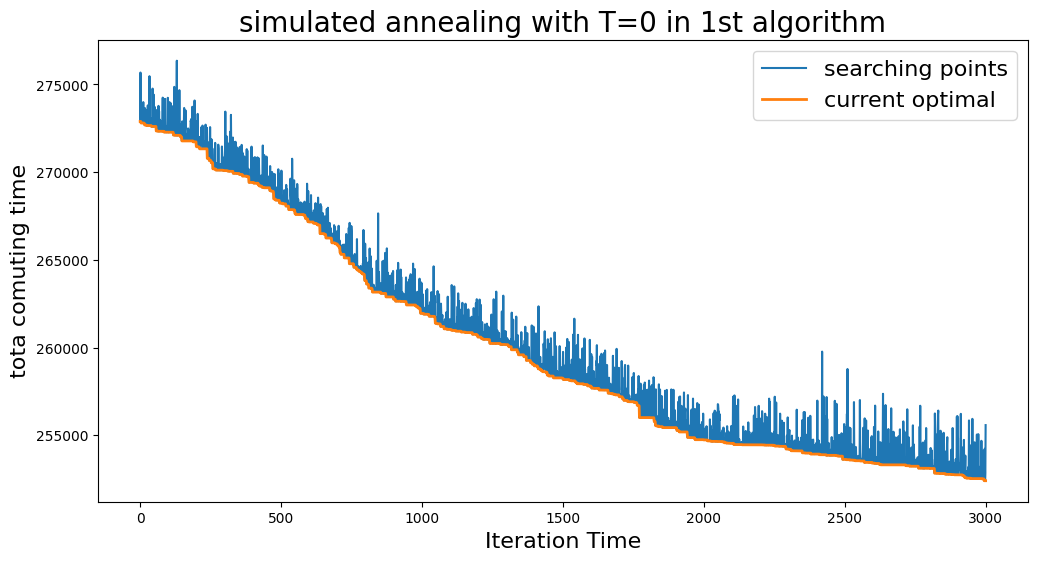

In [13]:
plt.figure(figsize=(12,6))
plt.plot(result, label='searching points')
plt.plot(temp, linewidth=2, label='current optimal')
plt.xlabel('Iteration Time', fontsize=16)
plt.ylabel('tota comuting time',fontsize=16)
plt.legend(fontsize=16)
plt.title('simulated annealing with T=0 in 1st algorithm', fontsize=20)

In [35]:
ref_time

272849.6999999893

In [36]:
costTime_best

261362.29999998954

In [14]:
df_schedule.to_csv('../result/df_schedule_al1_SA.csv')

In [15]:
pd.DataFrame(result).to_csv('../result/SA_al1_process.csv')